# Assessment of the incident power density on realistic spherical human head model

In [1]:
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import pandas as pd
from scipy.special import roots_legendre
from scipy.spatial import ConvexHull

from src.field import poynting
from src.utils.dataloader import (load_antenna_el_properties,
                                  load_sphere_coords)
from src.utils.derive import holoborodko
from src.utils.integrate import elementwise_dblquad
from src.utils.viz import fig_config, fig_config_reset

In [2]:
# jax.config.update("jax_enable_x64", True)

In [3]:
%config InlineBackend.figure_format = 'retina'

## Current distribution along the antenna operating in mmWave freq. spectrum

In [4]:
# load pre-computed source data

f = 10e9  # operating frequency of the antenna
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
Is = jnp.asarray(Is)
xs = antenna_data.x.to_numpy()
xs = jnp.asarray(xs)

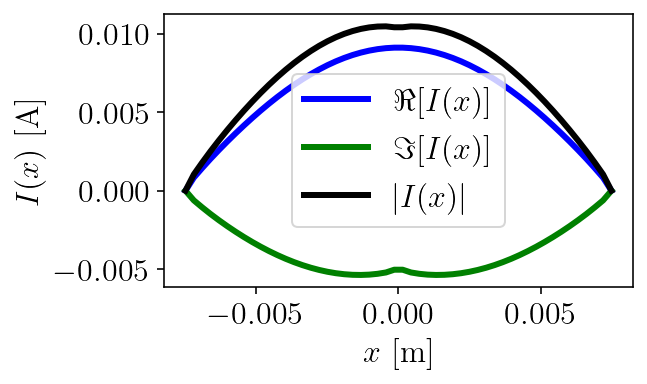

In [14]:
# visualize the complex spatial distribution of the current along the wire

fig_config(latex=True)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(xs, Is.real, 'b', label='$\\Re{[I(x)]}$')
ax.plot(xs, Is.imag, 'g', label='$\\Im{[I(x)]}$')
ax.plot(xs, jnp.abs(Is), 'k-', label=r'$|I(x)|$')
ax.set(xlabel=r'$x$ [m]', ylabel=r'$I(x)$ [A]')
ax.legend()
fig.tight_layout();

## Spherical model of human head in close proximity to the antenna (f.s. conditions)

In [6]:
# load pre-computed model coordinates

r_c = load_sphere_coords(2312)  # spherical head model coordinates

d = -5 / 1000  # distance between the head model and the antenna
xs = xs - xs.max() / 2
ys = jnp.zeros_like(xs) + r_c['y'].min() + d  # y-coordinates of the antenna
zs = jnp.zeros_like(xs)  # z-coordinates of the antenna
dx = xs[1] - xs[0]
Is_x = holoborodko(Is, dx)  # spatial distribution of current derivative

In [7]:
# compute power density values for each point of the sampled head model

S = r_c.apply(
    lambda row: poynting(row['x'], row['y'], row['z'], xs, ys, zs, f, Is, Is_x),
    axis=1, result_type='expand')
S.columns = ['Sx', 'Sy', 'Sz']
S_abs = S.apply(
    lambda row: jnp.sqrt(row['Sx'] ** 2 + row['Sy'] ** 2 + row['Sz'] ** 2),
    axis=1)
S.loc[:, 'S_abs'] = S_abs

# update dataframe
r_c_calc = pd.concat([r_c, S], axis=1)

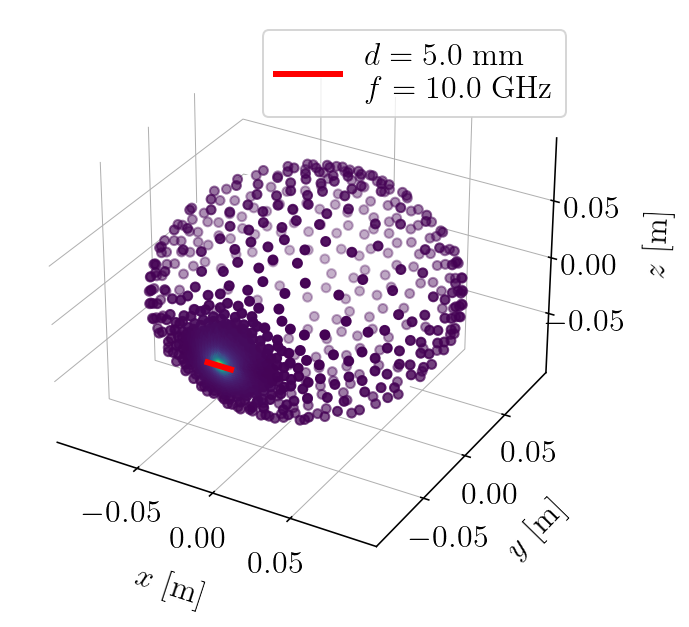

In [20]:
# visualize the absolute power density values on the head surface

hull = ConvexHull(r_c_calc[['x', 'y', 'z']].to_numpy())
triangle_coords = hull.points[hull.simplices]

fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.add_collection3d(Poly3DCollection(triangle_coords, color='white'))
ax.scatter(r_c_calc['x'], r_c_calc['y'], r_c_calc['z'],
           c=np.abs(r_c_calc['S_abs']))
ax.plot(xs, ys, zs, c='r', lw=3, zorder=4,
        label=(f'$d = {-d * 1000}$ mm\n'
               f'$f = {f / 1e9}$ GHz'))
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.05, 0.0, 0.05],
       yticks=[-0.05, 0.0, 0.05],
       zticks=[-0.05, 0.0, 0.05])
ax.set_xlim3d(-0.1, 0.1)
ax.set_ylim3d(-0.1, 0.1)
ax.set_zlim3d(-0.1, 0.1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.labelpad = 12
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 12

ax.legend()
fig.tight_layout();

In [9]:
# define the effective irradiated area for the computation of the incident power density

target_area = (2 / 100, 2 / 100)  # for freq. below 30 GHz
A = target_area[0] * target_area[1]
d = -5 / 1000  # distance from the antenna
target_area_origin = (-target_area[0]/2, -target_area[1]/2)

r_c_calc_ta = r_c_calc[
    (r_c_calc['y'] < 0) &
    (r_c_calc['x'] > target_area_origin[0]) &
    (r_c_calc['x'] < target_area_origin[0] * -1) &
    (r_c_calc['z'] > target_area_origin[1]) &
    (r_c_calc['z'] < target_area_origin[1] * -1)]
r_c_calc_ta.reset_index(drop=True, inplace=True)

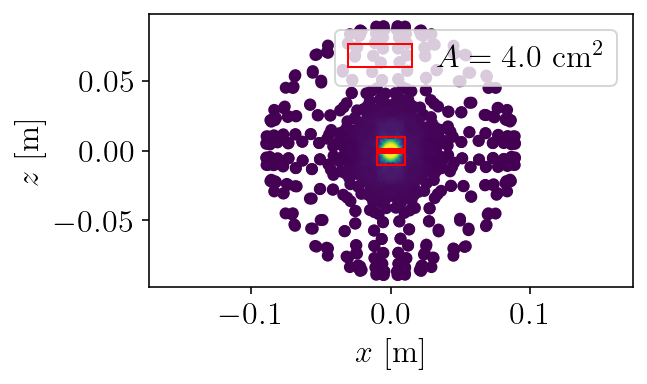

In [11]:
# visualize the absolute power density values on the head surface from the antenna point of view

fig_config(latex=True)
fig = plt.figure()
ax = fig.add_subplot()
ax.axis('equal')
cs = ax.scatter(r_c_calc['x'], r_c_calc['z'], c=np.abs(r_c_calc['S_abs']))
ax.plot(xs, zs, 'r-', lw=3)
ax.add_patch(Rectangle(target_area_origin, target_area[0], target_area[1],
                       ec='r', fc='None',
                       label=f'$A = {A * 1e4}$ cm$^2$'))
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$z$ [m]')
ax.legend(loc='upper right')
fig.tight_layout();

In [15]:
# extract the effective irradiated area

xt = r_c_calc_ta['x'].to_numpy()
yt = r_c_calc_ta['y'].to_numpy()
zt = r_c_calc_ta['z'].to_numpy()

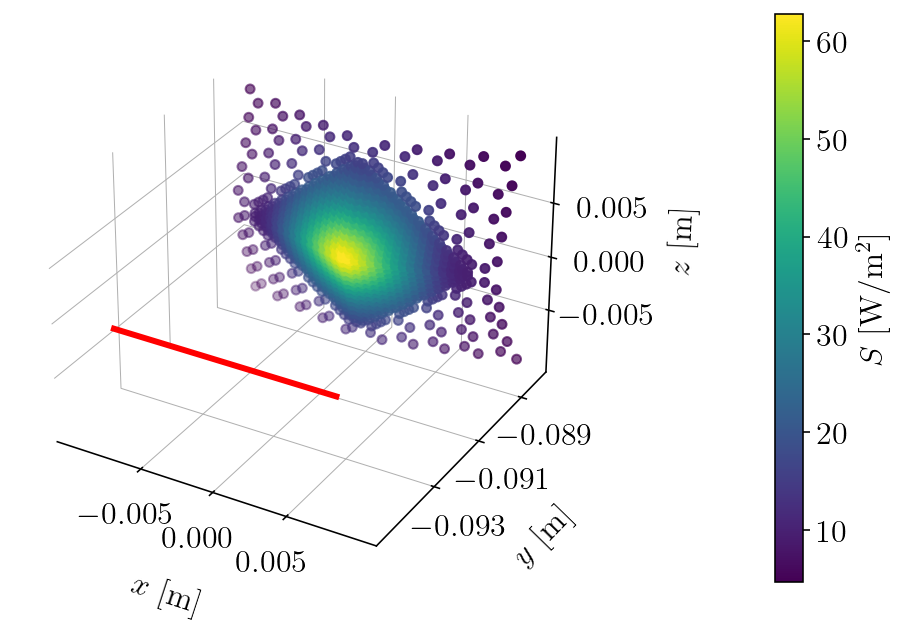

In [17]:
# visualize the absolute power density values on the effective irradiated area

fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')

cs = ax.scatter(xt, yt, zt, c=np.abs(r_c_calc_ta['S_abs']))
cbar = fig.colorbar(cs, pad=0.2)
cbar.ax.set_ylabel('$S$ [W/m$^2$]')
ax.plot(xs, ys, zs, linestyle='-', c='r', lw=3, zorder=1)
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20

fig.tight_layout();

In [18]:
# generate new coordinates withing a given boundaries

def cart2sph(x, y, z):
    """Return spherical given Cartesain coordinates."""
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    """Return Cartesian given Spherical coordinates."""
    x = r * jnp.cos(phi) * jnp.sin(theta)
    y = r * jnp.sin(phi) * jnp.sin(theta)
    z = r * jnp.cos(theta)
    return x, y, z


# generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
_, theta, phi = cart2sph(xt, yt, zt)
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
theta_points, theta_weights = roots_legendre(11)
phi_points, phi_weights = roots_legendre(11)
theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
phi_weights = 0.5 * phi_weights * (phi_b - phi_a)

r = 0.09  # radius of the head model
phi_grid, theta_grid = jnp.meshgrid(phi_points, theta_points)
xt_spherical, yt_spherical, zt_spherical = sph2cart(r, theta_grid.ravel(), phi_grid.ravel())

In [19]:
# compute the power density on the surface of the skin

Sx, Sy, Sz = [], [], []
for _xt, _yt, _zt in zip(xt_spherical, yt_spherical, zt_spherical):
    _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
    Sx.append(_Sx)
    Sy.append(_Sy)
    Sz.append(_Sz)
Sx = jnp.asarray(Sx)
Sy = jnp.asarray(Sy)
Sz = jnp.asarray(Sz)

S = jnp.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2)

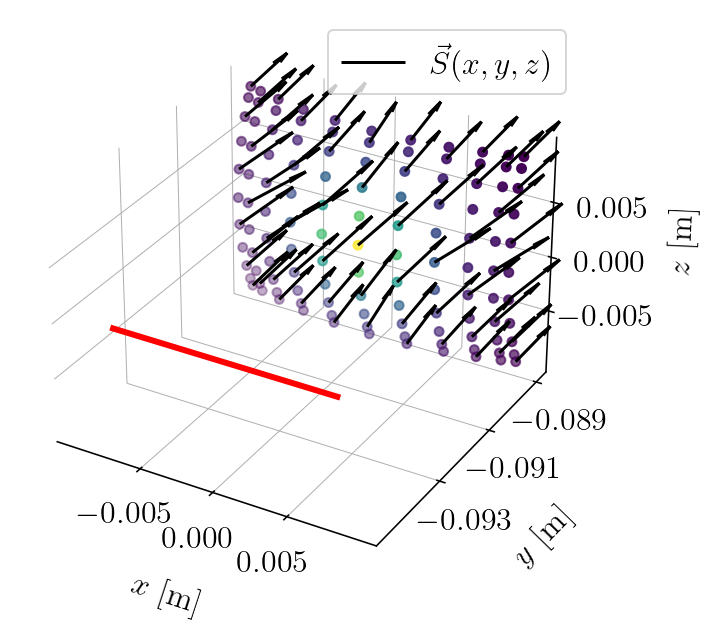

In [38]:
# visualize the power density on the surface of the skin inside the target area

fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot(xs, ys, zs, linestyle='-', c='r',)
ax.scatter(xt_spherical, yt_spherical, zt_spherical, c=jnp.abs(S))
ax.quiver(xt_spherical[::2], yt_spherical[::2], zt_spherical[::2],
          jnp.abs(Sx[::2]), jnp.abs(Sy[::2]), jnp.abs(Sz[::2]),
          linewidths=1.5,
          length=0.002, normalize=True, color='black',
          label='$\\vec{S}(x, y, z)$')
ax.set(xlabel='$x$ [m]', ylabel='$y$ [m]', zlabel='$z$ [m]',
       xticks=[-0.005, 0.0, 0.005],
       yticks=[-0.093, -0.091, -0.089],
       zticks=[-0.005, 0.0, 0.005])
ax.tick_params(axis='z', which='major', pad=10)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 20

ax.legend()
fig.tight_layout();

In [42]:
# compute the incident power density

poynting_mag = 0
A_spherical = 0
for _theta, _w_theta in zip(theta_points, theta_weights):
    for _phi, _w_phi in zip(phi_points, phi_weights):
        # normal vector components
        nx = r ** 2 * jnp.cos(_phi) * jnp.sin(_theta) ** 2 
        ny = r ** 2 * jnp.sin(_phi) * jnp.sin(_theta) ** 2
        nz = r ** 2 * jnp.cos(_theta) * jnp.sin(_theta)
        # power density vector field
        _xt, _yt, _zt = sph2cart(r, _theta, _phi)
        _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
        # dot product between power density and normal vector
        Fn = _Sx.real * nx + _Sy.real * ny + _Sz.real * nz
        # incident power integration
        poynting_mag += Fn * _w_theta * _w_phi
        # surface area integration
        A_spherical += jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
Sab = poynting_mag / (2 * A_spherical)

In [43]:
print(f'IPD = {Sab:.4f} W/m2')

IPD = 6.2050 W/m2


## Planar model of human head in close proximity to the antenna (f.s. conditions)

In [ ]:
# tba

## Comparisson between planar and spherical models

In [44]:
d = jnp.array([5, 10, 15, 25, 35, 45]) / -1000. # distance from the antenna
f = jnp.array([3.5, 6., 10., 26., 30., 60., 80., 100.])  # frequencies in GHz
p = 11  # number of root points

In [45]:
def cart2sph(x, y, z):
    """Return spherical given Cartesain coordinates."""
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return r, theta, phi


def sph2cart(r, theta, phi):
    """Return Cartesian given Spherical coordinates."""
    x = r * jnp.cos(phi) * jnp.sin(theta)
    y = r * jnp.sin(phi) * jnp.sin(theta)
    z = r * jnp.cos(theta)
    return x, y, z


def simulate(f, d, p):
    """Return Cartesian given Spherical coordinates."""
    assert f in [3.5, 6., 10., 26., 30., 60., 80., 100.]
    if f < 30:
        target_area = (2 / 100, 2 / 100)  # effective irradiated surface area, 4cm2
    else:
        target_area = (1 / 100, 1 / 100)  # effective irradiated surface area, 1cm2
    A = target_area[0] * target_area[1]  # area of the effective irradiated surface
    
    # source data
    f = f * 1e9
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    Is = jnp.asarray(Is)
    
    # antenna position -- coordinates for planar model
    xs = antenna_data.x.to_numpy()
    xs = jnp.asarray(xs)
    ys = jnp.zeros_like(xs)
    zs = jnp.zeros_like(xs)
    
    # target coordinates for planar model
    xt_planar = jnp.linspace(-target_area[0] / 2, target_area[0] / 2, p) + xs[-1] / 2
    yt_planar = jnp.linspace(-target_area[1] / 2, target_area[1] / 2, p)
    zt_planar = d
    
    # incident power density for planar model
    dx = xs[1] - xs[0]
    Is_x = holoborodko(Is, dx)
    S = np.empty((xt_planar.size, xt_planar.size), dtype=np.complex64)
    for xi, _xt in enumerate(xt_planar):
        for yi, _yt in enumerate(yt_planar):
            _Sx, _Sy, _Sz = poynting(_xt, _yt, zt_planar, xs, ys, zs, f, Is, Is_x)
            _S = jnp.sqrt(_Sx ** 2 + _Sy ** 2 + _Sz ** 2)
            S[xi, yi] = _S
    Sab_planar = 1 / (2 * A) * elementwise_dblquad(S.real, xt_planar, yt_planar, p)
       
    # target coordinates for curved model
    data = load_sphere_coords(2312)  # spherical head model coordinates
    target_area_origin = (-target_area[0]/2, -target_area[1]/2)
    data_target = data[  # effective irradiated skin surface
        (data['y'] < 0) &
        (data['x'] > target_area_origin[0]) &
        (data['x'] < target_area_origin[0] * -1) &
        (data['z'] > target_area_origin[1]) &
        (data['z'] < target_area_origin[1] * -1)]
    data_target.reset_index(drop=True, inplace=True)
    xt_spherical = data_target['x'].to_numpy()
    yt_spherical = data_target['y'].to_numpy()
    zt_spherical = data_target['z'].to_numpy()
    
    # antenna position -- coordinates for curved model
    xs = xs - xs.max() / 2
    ys = jnp.zeros_like(xs) + data_target['y'].min() + d
    zs = jnp.zeros_like(xs)
    dx = xs[1] - xs[0]
    Is_x = holoborodko(Is, dx)
    
    # generate Gaussian points in spherical c.s. and convert to Cartesian c.s.
    _, theta, phi = cart2sph(xt_spherical, yt_spherical, zt_spherical)
    theta_a = theta.min()
    theta_b = theta.max()
    phi_a = phi.min()
    phi_b = phi.max()
    theta_points, theta_weights = roots_legendre(p)
    phi_points, phi_weights = roots_legendre(p)
    theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
    theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
    phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
    phi_weights = 0.5 * phi_weights * (phi_b - phi_a)
    r = 0.09
    
    # incident power density for curved model
    poynting_mag = 0
    A = 0
    for _theta, _w_theta in zip(theta_points, theta_weights):
        for _phi, _w_phi in zip(phi_points, phi_weights):
            # normal vector components
            nx = r ** 2 * jnp.cos(_phi) * jnp.sin(_theta) ** 2 
            ny = r ** 2 * jnp.sin(_phi) * jnp.sin(_theta) ** 2
            nz = r ** 2 * jnp.cos(_theta) * jnp.sin(_theta)
            # power density vector field
            _xt, _yt, _zt = sph2cart(r, _theta, _phi)
            _Sx, _Sy, _Sz = poynting(_xt, _yt, _zt, xs, ys, zs, f, Is, Is_x)
            # dot product between power density and normal vector
            Fn = _Sx.real * nx + _Sy.real * ny + _Sz.real * nz
            # Gaussian quadrature
            poynting_mag += Fn * _w_theta * _w_phi
            A += jnp.sin(_theta) * r ** 2 * _w_theta * _w_phi
    Sab_spherical = poynting_mag / (2 * A)
    return Sab_planar.item(), Sab_spherical.item()

In [46]:
res = np.zeros((d.size * f.size, 5))
i = 0
for _d in d:
    for _f in f:
        Sab_planar, Sab_spherical = simulate(_f, _d, p)
        res[i, :] = [_f, _d, p, Sab_planar, Sab_spherical]
        i += 1

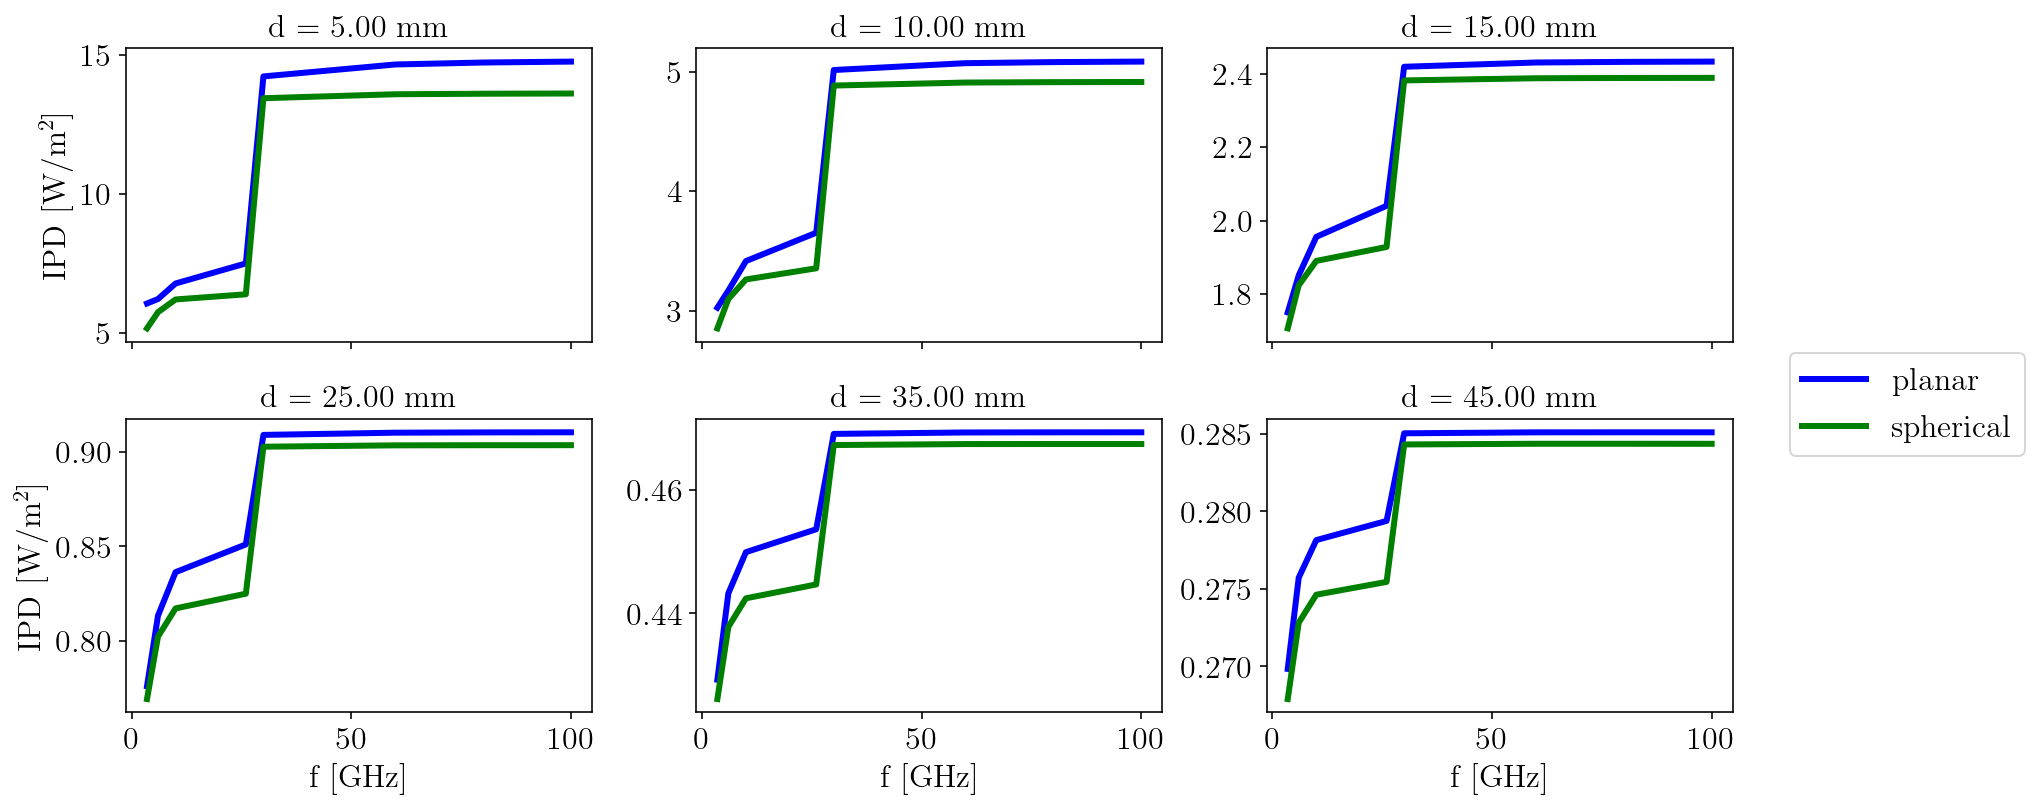

In [53]:
n_rows = 2
n_cols = 3
fig_config(latex=True, nrows=n_rows, ncols=n_cols)
fig = plt.figure()
axs = fig.subplots(n_rows, n_cols, sharex=True)
start_idx = 0
end_idx = f.size
d_idx = 0
for row in range(n_rows):
    for col in range(n_cols):
        axs[row, col].plot(f, res[start_idx:end_idx, 3], 'b-', lw=3, label='planar')
        axs[row, col].plot(f, res[start_idx:end_idx, 4], 'g-', lw=3, label='spherical')
        if col == 0:
            axs[row, col].set(ylabel='IPD [W/m$^2$]')
        if row == 1:
            axs[row, col].set(xlabel='f [GHz]')
        axs[row, col].set(title=f'd = ${np.abs(d[d_idx]) * 1e3:.2f}$ mm')
        start_idx = end_idx
        end_idx += f.size
        d_idx += 1
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.tight_layout()
fig.subplots_adjust(right=0.85);